# CIFAR examples

This code runs CIFAR10 and CIFAR100. To switch between these two datasets, update the `dataset` field in `train_config.yaml` and the `data_path` field in `audit.yaml` accordingly.


In [1]:
import os
import sys
import yaml

project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)


Next, we create the population dataset by concatenating the train and test data. To create the population, we make use of the UserDataset provided in the InputHandler.

In [2]:
from torchvision.datasets import CIFAR10, CIFAR100
from torch import cat, tensor
import pickle
from cifar_handler import CifarInputHandler

# Load the config.yaml file
with open('train_config.yaml', 'r') as file:
    train_config = yaml.safe_load(file)
    
root = train_config["data"]["data_dir"]
path = os.path.join(os.getcwd(), root)
# Load the CIFAR train and test datasets
if train_config["data"]["dataset"] == "cifar10":
    trainset = CIFAR10(root=root, train=True, download=True)
    testset = CIFAR10(root=root, train=False, download=True)
elif train_config["data"]["dataset"] == "cifar100":
    trainset = CIFAR100(root=root, train=True, download=True)
    testset = CIFAR100(root=root, train=False, download=True)
else:
    raise ValueError("Unknown dataset type")

train_data = tensor(trainset.data).permute(0, 3, 1, 2).float() / 255  # (N, C, H, W)
test_data = tensor(testset.data).permute(0, 3, 1, 2).float() / 255

# Ensure train and test data looks correct
assert train_data.shape[0] == 50000, "Train data should have 50000 samples"
assert test_data.shape[0] == 10000, "Test data should have 10000 samples"
assert train_data.shape[1] == 3, "Data should have 3 channels"
assert test_data.shape[1] == 3, "Data should have 3 channels"
assert train_data.max() <= 1 and train_data.min() >= 0, "Data should be normalized"
assert test_data.max() <= 1 and test_data.min() >= 0, "Data should be normalized"

# Concatenate train and test data into the population
data = cat([train_data.clone().detach(), test_data.clone().detach()], dim=0)
targets = cat([tensor(trainset.targets), tensor(testset.targets)], dim=0)
# Create UserDataset object
population_dataset = CifarInputHandler.UserDataset(data, targets)

assert len(population_dataset) == 60000, "Population dataset should have 60000 samples"

# Store the population dataset to be used by LeakPro
dataset_name = train_config["data"]["dataset"]
file_path =  "data/"+ dataset_name + ".pkl"
if not os.path.exists(file_path):
    with open(file_path, "wb") as file:
        pickle.dump(population_dataset, file)
        print(f"Save data to {file_path}")

/root/LeakPro/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



With the population dataset stored, we next create the train and test set that will go in to training the target model.

In [3]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy as np

train_fraction = train_config["data"]["f_train"]
test_fraction = train_config["data"]["f_test"]
batch_size = train_config["train"]["batch_size"]

dataset_size = len(population_dataset)
train_size = int(train_fraction * dataset_size)
test_size = int(test_fraction * dataset_size)

selected_index = np.random.choice(np.arange(dataset_size), train_size + test_size, replace=False)
train_indices, test_indices = train_test_split(selected_index, test_size=test_size)

train_subset = CifarInputHandler.UserDataset(data[train_indices], targets[train_indices])
test_subset = CifarInputHandler.UserDataset(data[test_indices], targets[test_indices], **train_subset.return_params())

train_loader = DataLoader(train_subset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = batch_size, shuffle = False)

# Evaluate mean and variance of the train data
train_mean = train_subset.mean
train_std = train_subset.std
print (f"Train mean: {train_mean}, Train std: {train_std}")

Train mean: tensor([[[0.4922]],

        [[0.4835]],

        [[0.4474]]]), Train std: tensor([[[0.2473]],

        [[0.2433]],

        [[0.2613]]])



With the train and test dataloader in place, we train a ResNet18. 
After training, we call LeakPro to create metadata that will be used during auditing.

In [4]:
from torch import save, optim, nn
from cifar_handler import CifarInputHandler
from target_model_class import ResNet18, WideResNet

# Train the model
if not os.path.exists("target"):
    os.makedirs("target")
if train_config["data"]["dataset"] == "cifar10":
    num_classes = 10
elif train_config["data"]["dataset"] == "cifar100":
    num_classes = 100
else:
    raise ValueError("Invalid dataset name")

# Create instance of target model
#model = ResNet18(num_classes = num_classes)
model =  WideResNet(depth=28, num_classes=num_classes, widen_factor=2)

# Read out the relevant parameters for training
lr = train_config["train"]["learning_rate"]
weight_decay = train_config["train"]["weight_decay"]
epochs = train_config["train"]["epochs"]
    
# Create optimizer and loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# train target model
train_result = CifarInputHandler().train(dataloader=train_loader,
                            model=model,
                            criterion=criterion,
                            optimizer=optimizer,
                            epochs=epochs)

# Evaluate on test set
test_result = CifarInputHandler().eval(test_loader, model, criterion)

# Store the model and metadata
model = train_result.model
model.to("cpu")
with open(train_config["run"]["log_dir"]+"/target_model.pkl", "wb") as f:
    save(model.state_dict(), f)

# Create metadata to be used by LeakPro
from leakpro import LeakPro
meta_data = LeakPro.make_mia_metadata(train_result = train_result,
                                      optimizer = optimizer,
                                      loss_fn = criterion,
                                      dataloader = train_loader,
                                      test_result = test_result,
                                      epochs = epochs,
                                      train_indices = train_indices,
                                      test_indices = test_indices,
                                      dataset_name = dataset_name)

with open("target/model_metadata.pkl", "wb") as f:
    pickle.dump(meta_data, f)
    

/root/LeakPro/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/LeakPro/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Epoch 2/2: 100%|██████████| 155/155 [00:03<00:00, 40.34it/s]


Plot accuracy and test of training and test.

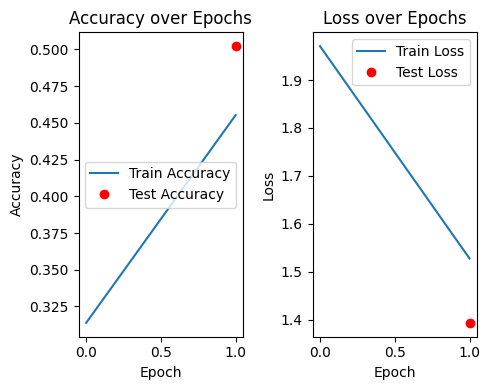

In [5]:
import matplotlib.pyplot as plt

train_acc = train_result.metrics.extra["accuracy_history"]
train_loss = train_result.metrics.extra["loss_history"]
test_acc = test_result.accuracy
test_loss = test_result.loss

# Plot training and test accuracy
plt.figure(figsize=(5, 4))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(len(train_loss)-1, test_acc, 'ro', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot training and test loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(len(train_loss)-1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

## Privacy Auditing using LeakPro

1. Create a LeakPro instance by feeding the CIFAR input handler.
2. Run the attacks defined in audit.yaml
    * Attacks are easily added/removed by simply adding to the audit.yaml
3. Obtain the result objects

In [6]:
# Read the config file
config_path = "audit.yaml"
from leakpro import LeakPro
from cifar_handler import CifarInputHandler

# Instantiate leakpro object
leakpro = LeakPro(CifarInputHandler, config_path)

# Run the audit 
mia_results = leakpro.run_audit(create_pdf=True)

2025-10-09 15:10:38,202 INFO     Target model blueprint created from ResNet18 in ./target_model_class.py.
10/09/2025 15:10:38:INFO:Target model blueprint created from ResNet18 in ./target_model_class.py.
2025-10-09 15:10:38,236 INFO     Loaded target model metadata from ./target/model_metadata.pkl
10/09/2025 15:10:38:INFO:Loaded target model metadata from ./target/model_metadata.pkl
2025-10-09 15:10:38,437 INFO     Loaded target model from ./target
10/09/2025 15:10:38:INFO:Loaded target model from ./target
2025-10-09 15:10:39,869 INFO     Loaded population dataset from ./data/cifar10.pkl
10/09/2025 15:10:39:INFO:Loaded population dataset from ./data/cifar10.pkl
2025-10-09 15:10:39,872 INFO     Image extension initialized.
10/09/2025 15:10:39:INFO:Image extension initialized.
2025-10-09 15:10:39,964 INFO     MIA attack factory loaded.
10/09/2025 15:10:39:INFO:MIA attack factory loaded.
2025-10-09 15:10:39,966 INFO     Creating shadow model handler singleton
10/09/2025 15:10:39:INFO:Crea

<Figure size 640x480 with 0 Axes>